Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras import backend as K
import matplotlib.pyplot as plt
import skimage
from skimage.metrics import structural_similarity as ssim
import time
import cv2
import scipy.stats as stats
import seaborn as sns
import scipy.io

Functions

In [ ]:
msel = tf.keras.losses.MeanSquaredError()

lamb = 0.001

def tffkdomain(input_tensor):
  input = input_tensor*2
  input -=1
  out = None
  for i in range(l1-num_delete_shots):
    Temp = input[:,:,:,i,:]
    inpp = tf.cast(Temp, tf.complex64)
    spectrum = tf.math.abs( tf.signal.fftshift(tf.signal.fft2d(inpp[0,:,:,:])) )
    div = tf.math.divide(spectrum,tf.reduce_max(spectrum))
    if out is not None:
      out = tf.concat([out, tf.expand_dims(div, -1)], axis=2)

    else:
      out = tf.expand_dims(div,-1)
  out = tf.expand_dims(out,0)
  return  out

def custom_loss_function(y_true, y_pred):
  mse = tf.keras.losses.MeanSquaredError()
  mse_value = mse(y_true, y_pred)
  fk_true = tffkdomain(y_true)
  fk_pred = tffkdomain(y_pred)
  mse_fk = mse(fk_true, fk_pred)
  return tf.add(mse_value,(lamb*mse_fk))

def fk_train(y_true, y_pred):
  mse = tf.keras.losses.MeanSquaredError()
  fk_true = tffkdomain(y_true)
  fk_pred = tffkdomain(y_pred)
  mse_fk = mse(fk_true, fk_pred)
  return lamb*mse_fk

def log10_(x):
  numerator = K.log(x)
  denominator = K.log(K.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def PSNR_train(y_true, y_pred):
  max_pixel = 1
  return 10.0 * log10_(  (max_pixel) / msel(y_true,y_pred)   )

def PSNR(y_true, y_pred):
  max_pixel = y_true.max()
  return 10.0 * log10_(  (max_pixel) / msel(y_true,y_pred)   )

def mse(vref, vcmp):

    if np.iscomplexobj(vref) or np.iscomplexobj(vcmp):
        dtype = np.complex128
    else:
        dtype = np.float64
    r = np.asarray(vref, dtype=dtype).ravel()
    c = np.asarray(vcmp, dtype=dtype).ravel()
    return np.mean(np.abs(r - c)**2)

def snr(vref, vcmp):

    dv = np.var(vref)
    with np.errstate(divide='ignore'):
        rt = dv / mse(vref, vcmp)
    return 10.0 * np.log10(rt)


def ssim_train(y_true, y_pred):
  max_val = 1
  return tf.image.ssim(y_true, y_pred, max_val)

Upload seismic data

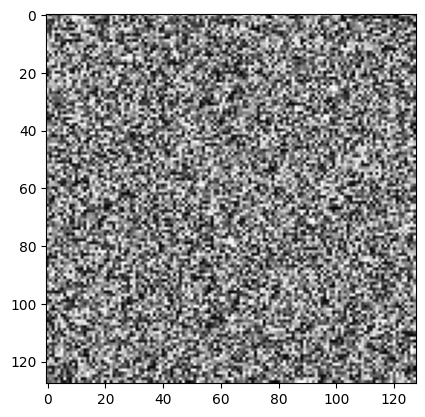

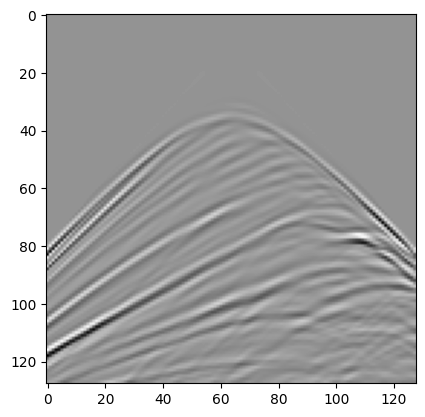

In [ ]:
m2 = 128
n2 = 128
l1 = 16

#----------------------------------------------------------------------

x = np.load('data/data_seismic_land_25m_16shots.npy')

a = 0
b = 1
x = a + (((x-np.min(x))*(b-a))/(np.max(x)-np.min(x)))

#----------------------------------------------------------------------

t = x.shape
m1 = t[0]
n1 = t[1]
l1 = t[2]

shots_delete = [3,5,7,10,12]
shots_p = [0,1,2,4,6,8,9,11,13,14,15]
num_delete_shots = 5

y_train = np.ndarray((1,m2,n2,l1-num_delete_shots,1),dtype="float32")
for i in range(l1-num_delete_shots):
    y_train[0,:,:,i,0] = x[:,:,shots_p[i]]

np.random.seed(0)
z_iter = np.random.rand(1,m2,n2,l1,1)
z_iter = np.float32(z_iter)

plt.imshow(z_iter[0,:,:,0,0],cmap='gray')
plt.show()

plt.imshow(y_train[0,:,:,10,0],cmap='gray')
plt.show()
z_iter = tf.convert_to_tensor(z_iter)

U-Net 3D

In [ ]:
def model_unet(pretrained_weights=None,input_size=(m2,n2,l1,1),FLAGS=None):
  inputs=Input(input_size)

  n = 16
  kernel= 3
  fun_act = "sigmoid"
  kernel_i =  tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)

  conv1 = Conv3D(n, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(inputs)
  bn1 = BatchNormalization()(conv1)
  relu1 = Activation(fun_act)(bn1)
  conv1 = Conv3D(n, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu1)
  bn1 = BatchNormalization()(conv1)
  relu1_sc = Activation(fun_act)(bn1)
  conv1 = Conv3D(n, kernel, strides=(2, 2, 2), padding="same", kernel_initializer=kernel_i)(relu1_sc)
  bn1 = BatchNormalization()(conv1)
  relu1 = Activation(fun_act)(bn1)

  conv2 = Conv3D(n*2, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu1)
  bn2 = BatchNormalization()(conv2)
  relu2 = Activation(fun_act)(bn2)
  conv2 = Conv3D(n*2, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu2)
  bn2 = BatchNormalization()(conv2)
  relu2_sc = Activation(fun_act)(bn2)
  conv2 = Conv3D(n*2, kernel_size = kernel, strides=(2, 2, 2), padding="same", kernel_initializer=kernel_i)(relu2_sc)
  bn2 = BatchNormalization()(conv2)
  relu2 = Activation(fun_act)(bn2)

  conv3 = Conv3D(n*4, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu2)
  bn3 = BatchNormalization()(conv3)
  relu3 = Activation(fun_act)(bn3)
  conv3 = Conv3D(n*4, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu3)
  bn3 = BatchNormalization()(conv3)
  relu3_sc = Activation(fun_act)(bn3)
  conv3 = Conv3D(n*4, kernel_size = kernel, strides=(2, 2, 2), padding="same", kernel_initializer=kernel_i)(relu3_sc)
  bn3 = BatchNormalization()(conv3)
  relu3 = Activation(fun_act)(bn3)

  conv4 = Conv3D(n*6, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu3)
  bn4 = BatchNormalization()(conv4)
  relu4 = Activation(fun_act)(bn4)
  conv4 = Conv3D(n*6, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu4)
  bn4 = BatchNormalization()(conv4)
  relu4_sc = Activation(fun_act)(bn4)
  conv4 = Conv3D(n*6, kernel_size = kernel, strides=(2, 2, 2), padding="same", kernel_initializer=kernel_i)(relu4_sc)
  bn4 = BatchNormalization()(conv4)
  relu4 = Activation(fun_act)(bn4)

  #middle
  conv5 = Conv3D(n*8, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu4)
  bn5 = BatchNormalization()(conv5)
  relu5 = Activation(fun_act)(bn5)
  conv5 = Conv3D(n*8, kernel_size = kernel, padding="same", kernel_initializer=kernel_i)(relu5)
  bn5 = BatchNormalization()(conv5)
  relu5 = Activation(fun_act)(bn5)
  up5 = UpSampling3D((2, 2, 2))(relu5)

  conv6 = Conv3D(n*6, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(up5)
  bn6 = BatchNormalization()(conv6)
  relu6 = Activation(fun_act)(bn6)
  sc6 = Add()([relu6, relu4_sc])
  conv6 = Conv3D(n*6, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(sc6)
  bn6 = BatchNormalization()(conv6)
  relu6 = Activation(fun_act)(bn6)
  conv6 = Conv3D(n*6, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(relu6)
  bn6 = BatchNormalization()(conv6)
  relu6 = Activation(fun_act)(bn6)
  up6 = UpSampling3D((2, 2, 2))(relu6)

  conv7 = Conv3D(n*4, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(up6)
  bn7 = BatchNormalization()(conv7)
  relu7 = Activation(fun_act)(bn7)
  sc7 = Add()([relu7, relu3_sc])
  conv7 = Conv3D(n*4, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(sc7)
  bn7 = BatchNormalization()(conv7)
  relu7 = Activation(fun_act)(bn7)
  conv7 = Conv3D(n*4, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(relu7)
  bn7 = BatchNormalization()(conv7)
  relu7 = Activation(fun_act)(bn7)
  up7 = UpSampling3D((2, 2, 2))(relu7)

  conv8 = Conv3D(n*2, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(up7)
  bn8 = BatchNormalization()(conv8)
  relu8 = Activation(fun_act)(bn8)
  sc8 = Add()([relu8, relu2_sc])
  conv8 = Conv3D(n*2, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(sc8)
  bn8 = BatchNormalization()(conv8)
  relu8 = Activation(fun_act)(bn8)
  conv8 = Conv3D(n*2, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(relu8)
  bn8 = BatchNormalization()(conv8)
  relu8 = Activation(fun_act)(bn8)
  up8 = UpSampling3D((2, 2, 2))(relu8)

  conv9 = Conv3D(n, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(up8)
  bn9 = BatchNormalization()(conv9)
  relu9 = Activation(fun_act)(bn9)
  sc9 = Add()([relu9, relu1_sc])
  conv9 = Conv3D(n, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(sc9)
  bn9 = BatchNormalization()(conv9)
  relu9 = Activation(fun_act)(bn9)
  conv9 = Conv3D(n, kernel_size = kernel,  padding="same", kernel_initializer=kernel_i)(relu9)
  bn9 = BatchNormalization()(conv9)
  relu9 = Activation(fun_act)(bn9)
  conv9 = Conv3D(1, kernel_size = 1,  padding="same", kernel_initializer=kernel_i)(relu9)
  bn9 = BatchNormalization()(conv9)
  relu9 = Activation('sigmoid')(bn9)

  output = Lambda(lambda x: tf.gather(x[0], x[1], axis=3))([relu9,shots_p])

  model = Model(inputs, output)

  if (pretrained_weights):
      model.load_weights(pretrained_weights)
  return model

unet = model_unet(input_size=(m2,n2,l1,1))
unet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                6, 1)]                                                            
                                                                                                  
 conv3d_108 (Conv3D)            (None, 128, 128, 16  448         ['input_5[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization_108 (Batch  (None, 128, 128, 16  64         ['conv3d_108[0][0]']             
 Normalization)                 , 16)                                                       

Training

In [ ]:
unet = model_unet(input_size=(m2,n2,l1,1))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=500,
    decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

unet.compile(optimizer=opt,loss=custom_loss_function,metrics=[PSNR_train,ssim_train,fk_train,msel])

history = unet.fit(z_iter,y_train,epochs=3000,batch_size=1, verbose='auto')

Epoch 1/3000


Se truncaron las últimas líneas 5000 del resultado de transmisión.
1/1 [==============================] - 0s 195ms/step - loss: 0.0064 - PSNR_train: 22.8228 - ssim_train: 0.6598 - fk_train: 0.0012 - mean_squared_error: 0.0052
Epoch 502/3000
1/1 [==============================] - 0s 212ms/step - loss: 0.0064 - PSNR_train: 22.8228 - ssim_train: 0.6598 - fk_train: 0.0012 - mean_squared_error: 0.0052
Epoch 503/3000
1/1 [==============================] - 0s 197ms/step - loss: 0.0064 - PSNR_train: 22.8228 - ssim_train: 0.6598 - fk_train: 0.0012 - mean_squared_error: 0.0052
Epoch 504/3000
1/1 [==============================] - 0s 200ms/step - loss: 0.0064 - PSNR_train: 22.8228 - ssim_train: 0.6598 - fk_train: 0.0012 - mean_squared_error: 0.0052
Epoch 505/3000
1/1 [==============================] - 0s 198ms/step - loss: 0.0064 - PSNR_train: 22.8228 - ssim_train: 0.6598 - fk_train: 0.0012 - mean_squared_error: 0.0052
Epoch 506/3000
1/1 [==============================] - 0s 194ms/step - loss: 0.

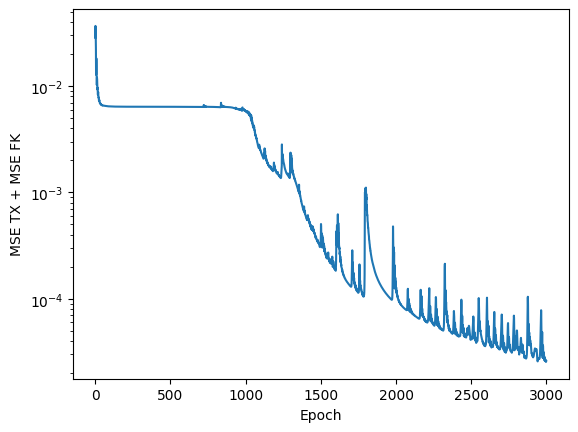

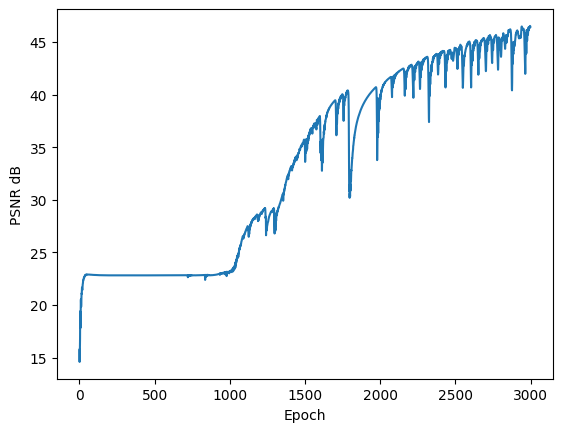

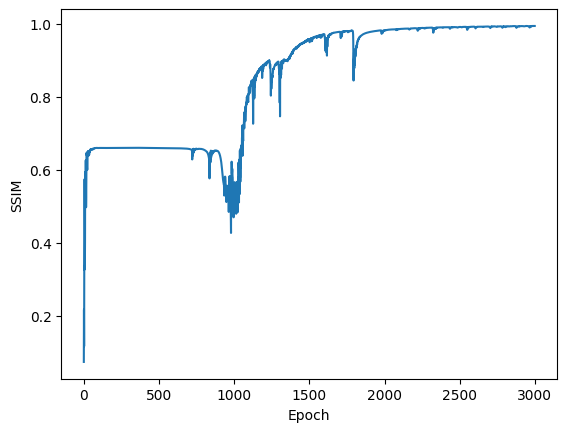

In [ ]:
plt.figure()
plt.semilogy(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE TX + MSE FK')
plt.show()
plt.plot(history.history['PSNR_train'])
plt.xlabel('Epoch')
plt.ylabel('PSNR dB')
plt.show()
plt.plot(history.history['ssim_train'])
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.show()

Reconstruction

In [ ]:
output = unet.layers[-2].output
unet_pred = Model(inputs = unet.input, outputs = output)

predict = unet_pred.predict(z_iter)

x_reconstructed = np.array(tf.squeeze(predict))

1/1 [==============================] - 1s 941ms/step


Shot -> 3


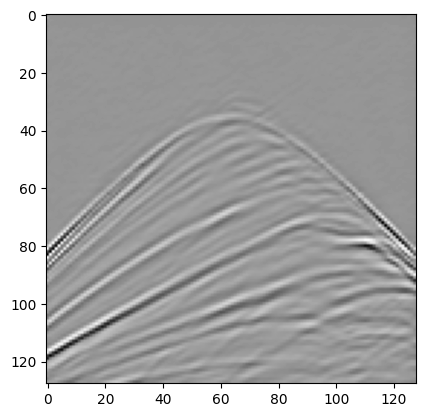

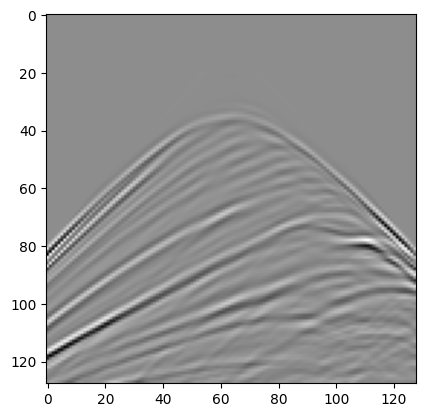

     MSE 0.0003418893838224665
     PSNR 34.5313
     SNR 10.71192
     SSIM 0.98777
Shot -> 5


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


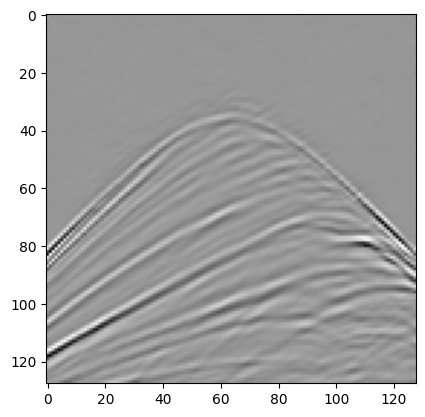

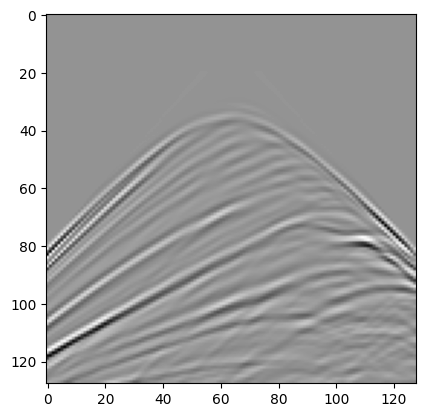

     MSE 0.00023580162349432103
     PSNR 35.93956
     SNR 12.25273
     SSIM 0.98474
Shot -> 7


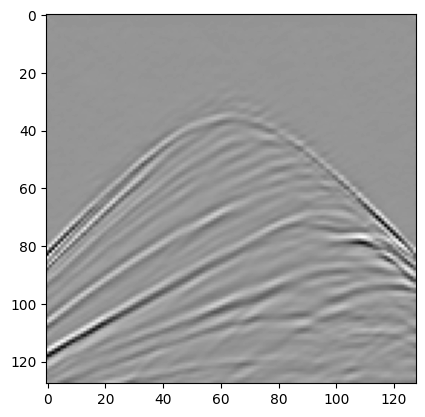

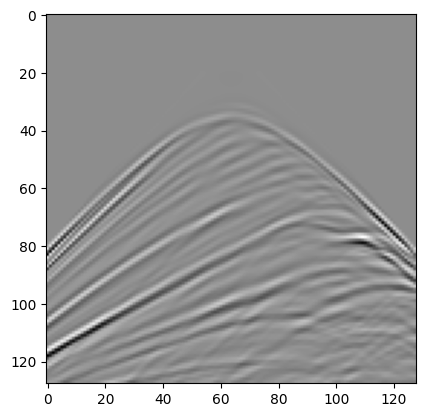

     MSE 0.0002384268781648615
     PSNR 36.08968
     SNR 12.14607
     SSIM 0.98281
Shot -> 10


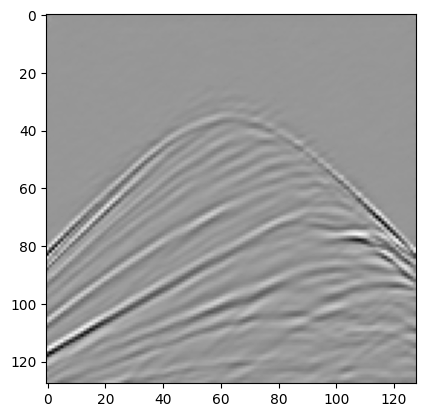

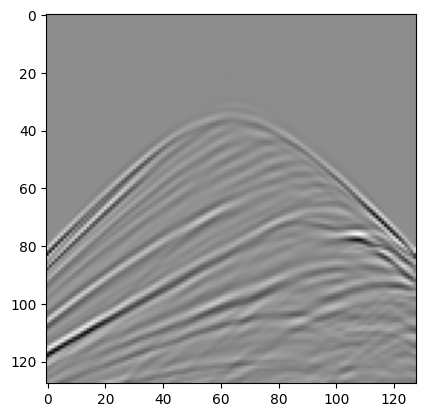

     MSE 0.00024056057022415244
     PSNR 36.0421
     SNR 12.0487
     SSIM 0.9837
Shot -> 12


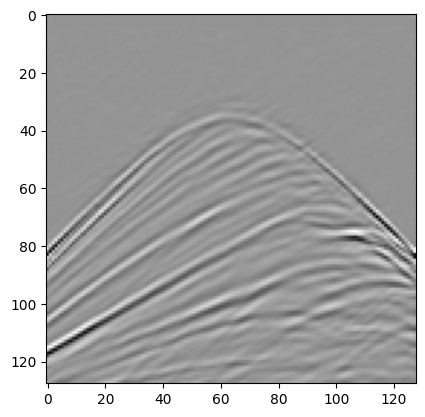

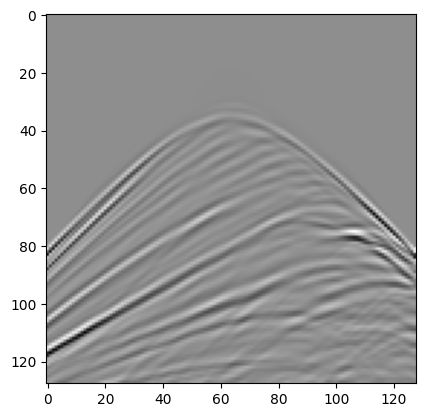

     MSE 0.00026335852480692946
     PSNR 35.6223
     SNR 11.72164
     SSIM 0.98639


In [ ]:
for i in range(num_delete_shots):
    print('Shot ->', shots_delete[i])
    plt.imshow(x_reconstructed[:,:,shots_delete[i]],cmap='gray')
    plt.show()
    plt.imshow(x[:,:,shots_delete[i]],cmap='gray')
    plt.show()
    print('     MSE', mse(x[:,:,shots_delete[i]], x_reconstructed[:,:,shots_delete[i]]))
    print('     PSNR', np.round(PSNR(x[:,:,shots_delete[i]], x_reconstructed[:,:,shots_delete[i]]).numpy(),5))
    print('     SNR', np.round(snr(x[:,:,shots_delete[i]], x_reconstructed[:,:,shots_delete[i]]),5))
    print('     SSIM', np.round(ssim(x[:,:,shots_delete[i]],  x_reconstructed[:,:,shots_delete[i]]),5))

Results

Export reconstructed data

In [ ]:
np.save('seismic_land_reconstructed.npy', x_reconstructed)